In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, os
import pandas as pd, numpy as np, seaborn as sn
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
sn.set_context('notebook')

# Spatial interpolation (part 2)

Datasets for the ECCO-DomQua project require spatial interpolation. The key data sources are described here:

K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC\Gridded_Data_Tasks.docx

The aim of this notebook is to develop code for converting data tables of latitude and longitude values (in Excel and CSV formats) into gridded spatial datasets that all have a consistent projection, bounding box and grid resolution. The work here builds upon the initial data exploration described in a [previous notebook]().

After chatting to Leah on 01/11/2016, we've decided to resample everything to **25 km resolution**, which is broadly compatible with the original EMEP resolution of 0.25 degrees latitude by 0.5 degrees longitude. 

Ideally, the code in this notebook should provide options for a variety of interpolation techniques, including at least one exact and one inexact interpolator (exact interpolators are ones where the fitted surface passes exactly through the original points). [This PDF](https://www.esri.com/news/arcuser/0704/files/interpolating.pdf) provides a summary of the various different options. 

We've already decided not to use kriging (an inexact method), as we can't really justify the assumptions required. **Inverse Distance Weighting (IDW)** is another inexact method that could be used, but it's often criticised as being innappropriate in most situations (see e.g. Joe Kington's comment to pv's answer in [this thread](http://stackoverflow.com/questions/6238250/multivariate-spline-interpolation-in-python-scipy)). Unfortunately, the commonly recommended alternative of using Radial Basis Functions (RBFs) is much more memory intensive, and leads to errors in all the tests I've performed so far with the ECCO-DomQua data. What's more, in situations where the data density is high (as is the case here), the choice of interpolation algorithm is less important, so IDW might turn out to be a pragmatic solution after all.

For exact methods, **cubic splines** are a promising option, but in section 5 of the [previous notebook]() they seemed to produce poor results. This may be due to outliers in the data forcing compression of the colour scale, because the surface must pass through all the outliers. I'd like to explore this effect in some more detail here.

In summary, this notebook will attempt to:

 1. Define a suitable projection and co-ordinate system for the spatial interpolation of Fenoscandian data <br><br>
 2. Implement IDW and spline interpolation for the EMEP and baseline chemistry datasets <br><br>
 3. Reproject and resample everything to a common 25 km resolution grid, so that datasets can be easily compared <br><br>
 4. Provide options for data visualisation, both directly in Python and also via ArcGIS (e.g. by outputting the results as GeoTiffs) <br><br>
 5. Compare my Python implementation with the output from ArcGIS, to make sure both workflows yield similar results
 
## 1. Define projection

The [previous notebook]() identified a suitably centred [Albers Equal Area Conic](https://en.wikipedia.org/wiki/Albers_projection) projection as being suitable for Fenoscandia. However, for my initial exploration of the data I ignored a number of important projection parameters, which need to be considered now if the output is to be genuinely comparable to the results obtained from ArcGIS.

The plot below shows the projection used in the [previous notebook](), together with [Tissot indicatrices](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) to illustrate the degree of distortion, which seems fairly small within the area of interest. 

By default, the `Basemap` constructor assumes a spherical model of the Earth with a radius of 6370997 m (as given by the `+R` parameter of the proj.4 string in the output below). In contrast, most modern GPS units are configured to use the `WGS84` ellipsoid, and in everything that follows **I'm assuming that the lat/long co-ordinates in Leah's data files are specified with reference to WGS84**. The difference between spherical and ellipsoidal models can be quite significant in some places, so we should modify the projection to allow for this.

+lon_0=15.0 +y_0=1000000.0 +R=6370997.0 +proj=aea +x_0=1000000.0 +units=m +lat_2=73.0 +lat_1=53.0 +lat_0=63.0 


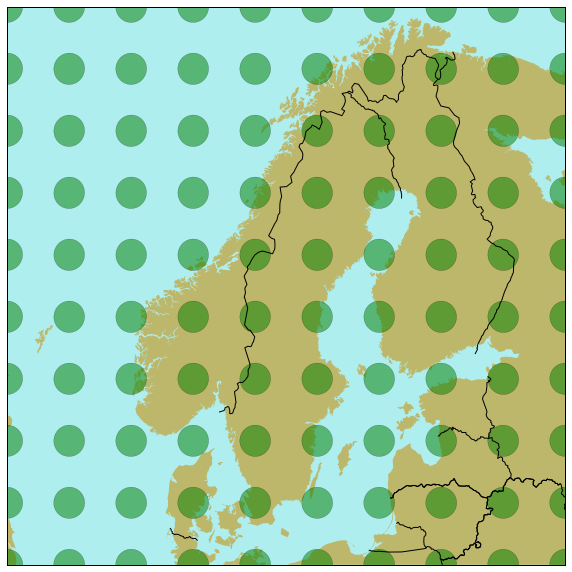

In [2]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63) # Central point

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Draw Tissot indicatrices to show distortion
for y in np.linspace(m.ymin/20, m.ymax, 10):
    for x in np.linspace(m.xmin, m.xmax, 10):
        lon, lat = m(x, y, inverse=True)
        poly = m.tissot(lon, lat,           # Location
                        0.5,                # Radius in degrees
                        100,                # N pts used to draw indicatrix
                        facecolor='green',
                        alpha=0.5)

print m.proj4string

To use the WGS84 ellipsoid we can pass and extra parameter, `ellps='WGS84'`, to the `Basemap` constructor. On the map below, the distortion of the Tissot indicatrices is still minimal, but note that the proj.4 string now includes extra parameters for the semi-major and semi-minor axes of the ellipsoid (`+a` and `+b`, respectively), rather than a single radius parameter (`+R`) for the spherical model. This projection should therefore be more compatible with the original point data, as well as comparable to the output from ArcGIS (which uses WGS84 by default).

Note that the extent of this map's bounding box does not quite cover the whole of the EMEP dataset, but it does cover the whole of Fenoscandia, which is what we're interested in here.

+a=6378137.0 +b=6356752.31425 +y_0=1000000.0 +lon_0=15.0 +proj=aea +x_0=1000000.0 +units=m +lat_2=73.0 +lat_1=53.0 +lat_0=63.0 


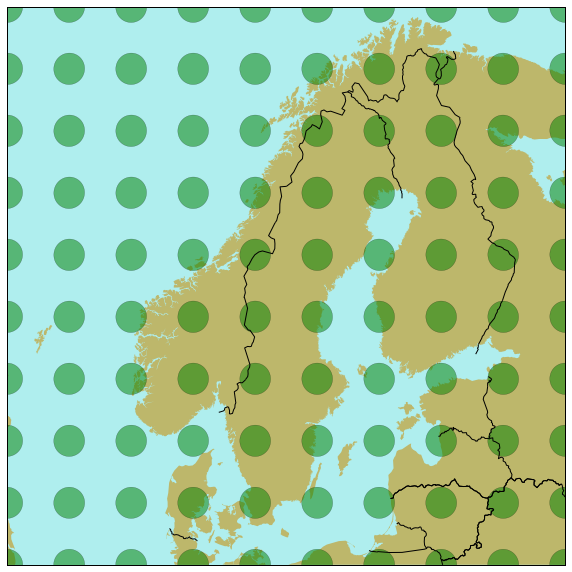

In [3]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63, # Central point
            ellps='WGS84')     # http://matplotlib.org/basemap/api/basemap_api.html

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Draw Tissot indicatrices to show distortion
for y in np.linspace(m.ymin/20, m.ymax, 10):
    for x in np.linspace(m.xmin, m.xmax, 10):
        lon, lat = m(x, y, inverse=True)
        poly = m.tissot(lon, lat,           # Location
                        0.5,                # Radius in degrees
                        100,                # N pts used to draw indicatrix
                        facecolor='green',
                        alpha=0.5)

print m.proj4string

### 1.2. Define projection in ArcGIS

As far as I can see, ArcGIS does not have a suitable "off-the-shelf" projection for the whole of Fenoscandia, so I've created a custom projection using the Basemap parameters identified above (i.e. using the information in the proj.4 string). I've named this projection `Albers_Equal_Area_Fenoscandia` and the key parameters are as follows:

    Albers_Equal_Area_Fenoscandia
    Authority: Custom

    Projection: Albers
    False_Easting: 1000000.0
    False_Northing: 1000000.0
    Central_Meridian: 15.0
    Standard_Parallel_1: 53.0
    Standard_Parallel_2: 73.0
    Latitude_Of_Origin: 63.0
    Linear Unit: Meter (1.0)

    Geographic Coordinate System: GCS_WGS_1984
    Angular Unit: Degree (0.0174532925199433)
    Prime Meridian: Greenwich (0.0)
    Datum: D_WGS_1984
      Spheroid: WGS_1984
        Semimajor Axis: 6378137.0
        Semiminor Axis: 6356752.314245179
        Inverse Flattening: 298.257223563

For the rest of this notebook, **I'm proposing to use a 25 km grid based on the map extent shown above as the basis for all the grid calculations**.

## 2. Read raw data

Leah's Word document provides paths to the raw data files. The EMEP data is stored in comma-delimited format as `S_LoLa_a.FNS` and the chemistry data is in an Excel file called `Nordic_data_GIS_Import.xlsx`. I've made local, Excel-based copies of both these files, which are used in the code below. 

In [4]:
# Read EMEP
emep_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\S_LoLa_a_tidy.xlsx')
emep_df = pd.read_excel(emep_xlsx, sheetname='Sheet1')

emep_df.head()

,Lon,Lat,1880,1885,1890,1895,1900,1905,1910,1915,...,1975,1980,1985,1990,1995,2000,2005,2010,2020,2030
0,7.5,54.0,557.0,630.3,735.3,791.5,960.1,1044.2,1217.7,1264.0,...,3469.8,3554.3,2832.7,2353.4,1172.4,767.1,629.3,481.1,237.9,200.9
1,8.5,54.0,537.2,619.0,729.4,791.2,973.0,1068.6,1263.2,1313.2,...,3960.8,4115.2,3179.9,2664.0,1226.6,791.2,643.4,492.8,261.4,220.4
2,9.0,54.0,504.2,586.3,695.6,761.0,943.1,1044.2,1242.0,1304.7,...,4264.2,4437.3,3443.9,3056.1,1271.8,805.6,654.7,510.8,284.8,241.9
3,9.5,54.0,482.0,566.0,676.7,746.7,932.7,1040.8,1245.7,1320.6,...,4612.2,4806.9,3868.9,3905.3,1426.0,884.0,720.0,581.6,344.9,293.0
4,10.0,54.0,482.0,567.8,680.8,753.4,943.5,1055.4,1266.2,1345.3,...,4802.9,5013.2,4366.7,3186.4,1191.0,736.0,600.0,486.4,287.2,245.6


In [5]:
# Read chemistry
chem_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\ECCO_Spat_Interp\Nordic_data_GIS_Import.xlsx')
chem_df = pd.read_excel(chem_xlsx, sheetname='Nordic95_LakeChem_SiteProprties')

chem_df.head()

,Station_ID,Lat,Long,Country,TOC,Cl,nmCaMg,SO4,nmSO4
0,9,59.00,11.56,Norway,10.0,174.87,66.76,99.93,81.92
1,10,59.80,11.85,Norway,11.7,53.59,81.82,62.45,56.94
2,11,60.05,12.44,Norway,12.1,42.30,105.92,62.45,58.10
3,12,60.32,11.84,Norway,8.0,28.20,43.08,56.21,53.30
4,13,60.59,12.51,Norway,9.3,22.56,83.41,54.13,51.80


## 3. Plot data

Before interpolating anything, let's plot the two datasets to see what the distribution of points looks like.

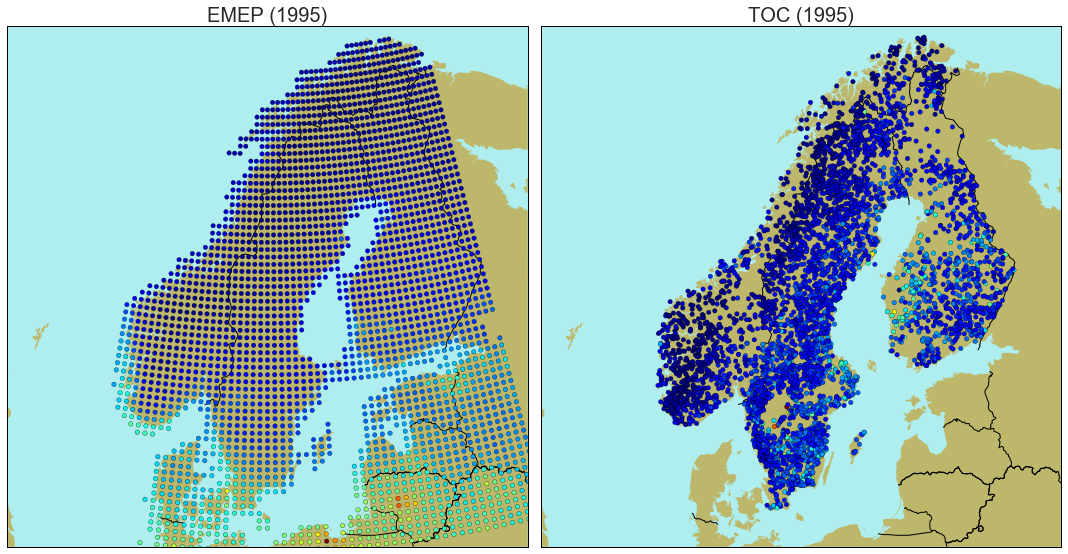

In [6]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(15, 10))

# 1. Plot EMEP
ax = fig.add_subplot(1, 2, 1)

# 1.1. Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# 1.2. Map (long, lat) to (x, y) for plotting
x, y = m(emep_df['Lon'].values, emep_df['Lat'].values)

# 1.3. Add points
ax.scatter(x, y, c=emep_df[1995].values, cmap='jet', zorder=5)
ax.set_title('EMEP (1995)', fontsize=20)

# 2. Plot Chem
ax = fig.add_subplot(1, 2, 2)

# 2.1. Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# 2.2. Map (long, lat) to (x, y) for plotting
x, y = m(chem_df['Long'].values, chem_df['Lat'].values)

# 2.3. Add points
ax.scatter(x, y, c=chem_df['TOC'].values, cmap='jet', zorder=5)
ax.set_title('TOC (1995)', fontsize=20)

plt.tight_layout()

The point density for both datasets looks pretty good. With sufficient data, the choice of interpolation algorithm becomes less important, as the requirement for the algorithm to give sensible "out-of-sample" predictions is reduced. 

A bit of manual experimentation using ArcGIS suggests that, in the chosen projected co-ordinate system, the point spacing for the EMEP data is always about 28 km from north to south, and ranges from 18 to 32 km east to west. Choosing to interpolate the data onto a 25 km resolution grid therefore seems like a reasonable compromise.

## 4. Interpolation

### 4.1. IDW

The code below is taken from [this Stackoverflow post](http://stackoverflow.com/questions/3104781/inverse-distance-weighted-idw-interpolation-with-python). For this raw code and a 2D example, the inputs are:

 * A 2D array of (x, y) pairs for the known points, of shape (N, 2)
 * A 1D array of length N containing the 'z values' to interpolate
 
The main interpolation options to consider varying are `Nnear` and `p`. The former is the number of nearby points to use in the calculation of the IDW average; the latter affects the rate at which a point's influence decreases with distance. For example, when $p = 1$ the weights decline as $w \propto \frac{1}{dist}$, whereas when $p = 2$ they decline as $w \propto \frac{1}{dist^2}$.

First, the interpolator object is created using e.g.

    invdisttree = Invdisttree(xy_2D_array, z_1D_array)
    
and then interpolation itself is performed by calling e.g.

    interpol = invdisttree(ask, nnear=Nnear, p=p)
    
where `ask` is a 2D array of (x, y) pairs defining the co-ordinates of interest and the output is a 1D array of interpolated values for each (x, y) point in `ask`.

In [7]:
""" invdisttree.py: inverse-distance-weighted interpolation using KDTree
    fast, solid, local
"""
from __future__ import division
import numpy as np
from scipy.spatial import cKDTree as KDTree
    # http://docs.scipy.org/doc/scipy/reference/spatial.html

__date__ = "2010-11-09 Nov"  # weights, doc

#...............................................................................
class Invdisttree:
    """ inverse-distance-weighted interpolation using KDTree:
invdisttree = Invdisttree( X, z )  -- data points, values
interpol = invdisttree( q, nnear=3, eps=0, p=1, weights=None, stat=0 )
    interpolates z from the 3 points nearest each query point q;
    For example, interpol[ a query point q ]
    finds the 3 data points nearest q, at distances d1 d2 d3
    and returns the IDW average of the values z1 z2 z3
        (z1/d1 + z2/d2 + z3/d3)
        / (1/d1 + 1/d2 + 1/d3)
        = .55 z1 + .27 z2 + .18 z3  for distances 1 2 3

    q may be one point, or a batch of points.
    eps: approximate nearest, dist <= (1 + eps) * true nearest
    p: use 1 / distance**p
    weights: optional multipliers for 1 / distance**p, of the same shape as q
    stat: accumulate wsum, wn for average weights

How many nearest neighbors should one take ?
a) start with 8 11 14 .. 28 in 2d 3d 4d .. 10d; see Wendel's formula
b) make 3 runs with nnear= e.g. 6 8 10, and look at the results --
    |interpol 6 - interpol 8| etc., or |f - interpol*| if you have f(q).
    I find that runtimes don't increase much at all with nnear -- ymmv.

p=1, p=2 ?
    p=2 weights nearer points more, farther points less.
    In 2d, the circles around query points have areas ~ distance**2,
    so p=2 is inverse-area weighting. For example,
        (z1/area1 + z2/area2 + z3/area3)
        / (1/area1 + 1/area2 + 1/area3)
        = .74 z1 + .18 z2 + .08 z3  for distances 1 2 3
    Similarly, in 3d, p=3 is inverse-volume weighting.

Scaling:
    if different X coordinates measure different things, Euclidean distance
    can be way off.  For example, if X0 is in the range 0 to 1
    but X1 0 to 1000, the X1 distances will swamp X0;
    rescale the data, i.e. make X0.std() ~= X1.std() .

A nice property of IDW is that it's scale-free around query points:
if I have values z1 z2 z3 from 3 points at distances d1 d2 d3,
the IDW average
    (z1/d1 + z2/d2 + z3/d3)
    / (1/d1 + 1/d2 + 1/d3)
is the same for distances 1 2 3, or 10 20 30 -- only the ratios matter.
In contrast, the commonly-used Gaussian kernel exp( - (distance/h)**2 )
is exceedingly sensitive to distance and to h.

    """
    def __init__( self, X, z, leafsize=10, stat=0 ):
        assert len(X) == len(z), "len(X) %d != len(z) %d" % (len(X), len(z))
        self.tree = KDTree( X, leafsize=leafsize )  # build the tree
        self.z = z
        self.stat = stat
        self.wn = 0
        self.wsum = None;

    def __call__( self, q, nnear=6, eps=0, p=1, weights=None ):
            # nnear nearest neighbours of each query point --
        q = np.asarray(q)
        qdim = q.ndim
        if qdim == 1:
            q = np.array([q])
        if self.wsum is None:
            self.wsum = np.zeros(nnear)

        self.distances, self.ix = self.tree.query( q, k=nnear, eps=eps )
        interpol = np.zeros( (len(self.distances),) + np.shape(self.z[0]) )
        jinterpol = 0
        for dist, ix in zip( self.distances, self.ix ):
            if nnear == 1:
                wz = self.z[ix]
            elif dist[0] < 1e-10:
                wz = self.z[ix[0]]
            else:  # weight z s by 1/dist --
                w = 1 / dist**p
                if weights is not None:
                    w *= weights[ix]  # >= 0
                w /= np.sum(w)
                wz = np.dot( w, self.z[ix] )
                if self.stat:
                    self.wn += 1
                    self.wsum += w
            interpol[jinterpol] = wz
            jinterpol += 1
        return interpol if qdim > 1  else interpol[0]

This code is great, but it would be nicer if it took inputs in a similar format to `scipy.interpolate.griddata`, which I'll be using for spline interpolation later. The function below wraps the IDW code from Stackoverflow, but reformats the inputs and outputs so that the interface is a bit more consistent.

In [8]:
def idw_interp(pts, z, xi, yi, n_near=8, p=1):
    """ Simplified interface to Invdisttree class.
    
    Args:
        pts    2D array of (x, y) pairs for known points
        z      1D array of values to interpolate
        xi     1D array of x values to interpolate 
        yi     1D array of y values to interpolate  
        n_near The number of nearest neighbours to consider
        p      Power defining rate at which weights decrease with distance
    """   
    # Build interpolator
    invdisttree = Invdisttree(pts, z)
    
    # Build list of co-ords to interpolate
    xx, yy = np.meshgrid(xi, yi)    
    pts_i = np.array(zip(xx.flatten(), yy.flatten()))
    
    # Perform interpolation
    interpol = invdisttree(pts_i, nnear=n_near, p=p)
    
    # Reshape output
    zi = interpol.reshape((len(yi), len(xi)))
    
    return zi

### 4.2. Splines

`scipy.interpolate` has a `griddata` function that can be used to fit piecewise cubic splines in 2D. This same function also has options for `nearest` and `linear` interpolation (see the [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.griddata.html)), which could be worth exploring too. The use of this function is demonstrated in section 5 of the [previous notebook]().

### 4.3. Compare IDW and cubic splines

The code below applies three interpolation methods (IDW with p=1; IDW with p=2 and cubic splines) to the 1995 EMEP data and plots the results.

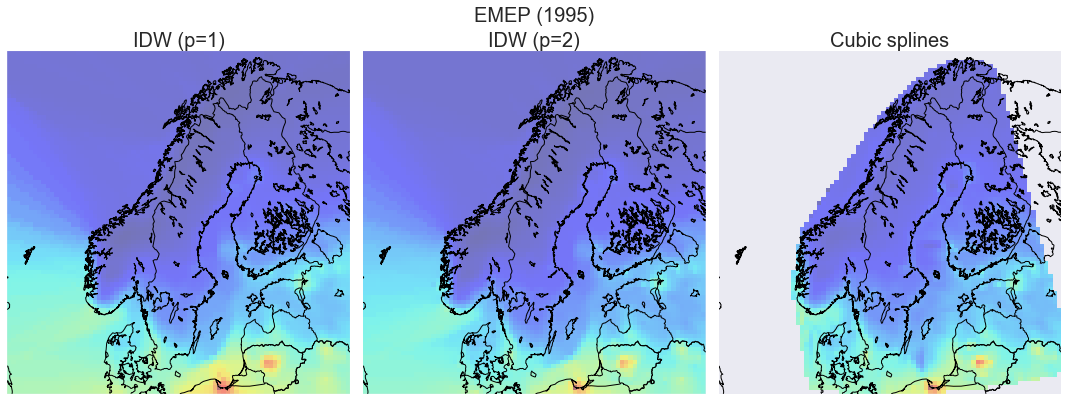

In [9]:
# Set up 25 km grid for interpolation
gridx = np.arange(int(m.xmin), int(m.xmax), 25000)
gridy = np.arange(int(m.ymin), int(m.ymax), 25000)

# Map (long, lat) to projected (x, y)
x, y = m(emep_df['Lon'].values, emep_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))
vals = emep_df[1995].values

# Plot
fig = plt.figure(figsize=(15, 10))

# 1. IDW with p=1
ax = fig.add_subplot(1, 3, 1)

# Perform interpolation
grid = idw_interp(pts, vals, gridx, gridy)

ax.set_title('IDW (p=1)', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 2. IDW with p=2
ax = fig.add_subplot(1, 3, 2)

# Perform interpolation
grid = idw_interp(pts, vals, gridx, gridy, p=2)

ax.set_title('IDW (p=2)', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 3. Splines
# Grid to interpolate
xx, yy = np.meshgrid(gridx, gridy) 

ax = fig.add_subplot(1, 3, 3)

# Perform interpolation
grid = griddata(pts, vals, (xx, yy), method='cubic')

ax.set_title('Cubic splines', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

plt.suptitle('EMEP (1995)', fontsize=20, y=0.8)
plt.tight_layout()

These results look pretty good. One thing to note is that the splines implementation in `griddata` does some fairly sensible clipping of the output so that it's not extrapolating too far beyond the regions with data, whereas my IDW version estimates values for the whole array. In the end, I'll probably **create a 25 km grid with ones for the land and NaNs everywhere else**, which I can use as a multiplier to remove wildly extrapolated values. 

### 4.4. Data scaling

So far I've only tried interpolating the EMEP data, but the water chemistry dataset is larger and has caused memory errors with some of interpolation algorithms I've tested in the past. I hope the implementations above will be fairly robust, but before I go any further I'd like to try interpolating `chem_df` as well, just to check that what I've done so far can handle the data volumes involved in the ECCO-DomQua project.

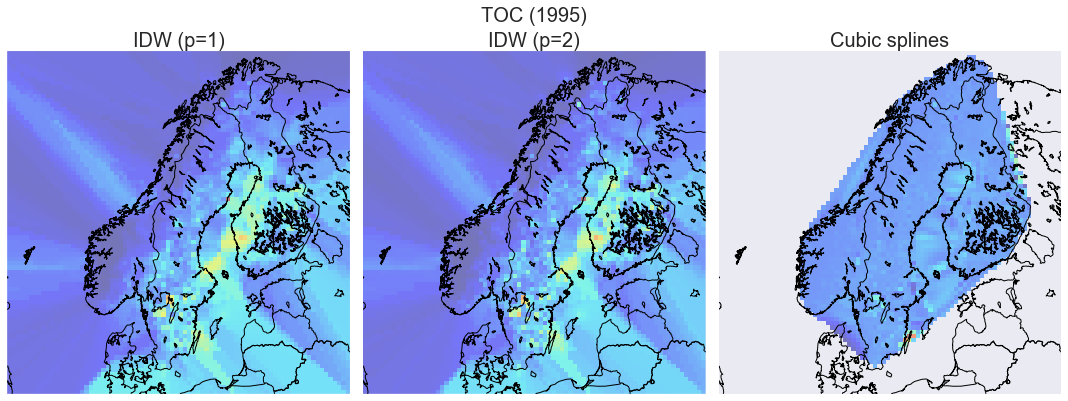

In [10]:
# Set up 25 km grid for interpolation
gridx = np.arange(int(m.xmin), int(m.xmax), 25000)
gridy = np.arange(int(m.ymin), int(m.ymax), 25000)

# Map (long, lat) to projected (x, y)
x, y = m(chem_df['Long'].values, chem_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))
vals = chem_df['TOC'].values

# Plot
fig = plt.figure(figsize=(15, 10))

# 1. IDW with p=1
ax = fig.add_subplot(1, 3, 1)

# Perform interpolation
grid = idw_interp(pts, vals, gridx, gridy)

ax.set_title('IDW (p=1)', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 1. IDW with p=2
ax = fig.add_subplot(1, 3, 2)

# Perform interpolation
grid = idw_interp(pts, vals, gridx, gridy, p=2)

ax.set_title('IDW (p=2)', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 3. Splines
# Grid to interpolate
xx, yy = np.meshgrid(gridx, gridy) 

ax = fig.add_subplot(1, 3, 3)

# Perform interpolation
grid = griddata(pts, vals, (xx, yy), method='cubic')

ax.set_title('Cubic splines', fontsize=20)
m.imshow(grid, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

plt.suptitle('TOC (1995)', fontsize=20, y=0.8)
plt.tight_layout()

This seems to work OK too, which is great. The splines version looks quite different to the output from IDW, but I suspect this is due to outlier(s): it's looks as though there's at least one data point towards south-eastern edge of the map where TOC levels are very high. Because the splines algorithm fits the data points exactly, the fitted surface is being pulled up here and this, in turn, is compressing the colour scale elsewhere. IDW is inexact, so it smooths things out a bit more.

## 5. Write output to GeoTiff

The next step is to work out how to save these arrays as GeoTiffs, so they can be easily added to e.g. ArcGIS. This usually isn't too difficult, but because I'm using a custom projection I suspect things will be a bit more complicated. The function below is modified from my old NIRAMS II code.

In [11]:
def array_to_gtiff(xmin, ymax, cell_size, out_path, data_array,
                   proj4_str, no_data_value=-9999):
    """ Save numpy array as GeoTiff (in a projected co-ordinate system).
    
    Args:
        xmin:          Minimum x value in metres
        ymax:          Maximum y value in metres
        cell_size:     Grid cell size in metres
        out_path:      Path to GeoTiff
        data:          Array to save 
        proj4_str      proj.4 string defining the projection
        no_data_value: Value to use to represent no data 
        
    Returns:
        None. Array is saved to specified path.
    """
    # Import modules
    import gdal, gdalconst, osr

    # Explicitly set NDV
    data_array[np.isnan(data_array)] = no_data_value
    
    # Flip. Not sure why this is necessary? Without it the 
    # output grid is upside down! Haven't had this problem before,
    # but this seems to work here. Beware in future!
    data_array = data_array[::-1,:]

    # Get array shape
    cols = data_array.shape[1]
    rows = data_array.shape[0]

    # Get driver
    driver = gdal.GetDriverByName('GTiff')

    # Create a new raster data source
    out_ds = driver.Create(out_path, cols, rows, 1, gdal.GDT_Float32)

    # Get spatial reference
    sr = osr.SpatialReference()
    sr.ImportFromProj4(proj4_str)
    sr_wkt = sr.ExportToWkt()

    # Write metadata
    # (xmin, cellsize, 0, ymax, 0, -cellsize)
    out_ds.SetGeoTransform((int(xmin), cell_size, 0.0, 
                            int(ymax), 0.0, -cell_size)) 
    out_ds.SetProjection(sr_wkt)
    out_band = out_ds.GetRasterBand(1)
    out_band.SetNoDataValue(-9999)
    out_band.WriteArray(data_array)

    # Tidy up
    del out_ds, out_band

Having defined this function, output arrays can be written to GeoTiff format and then added to e.g. ArcMap. 

## 6. Comparison to ArcGIS

The code below interpolates the EMEP data for 1995, using both IDW (p=2) and cubic splines. The results are saved to GeoTiff format for comparison with output obtained manually using ArcGIS.

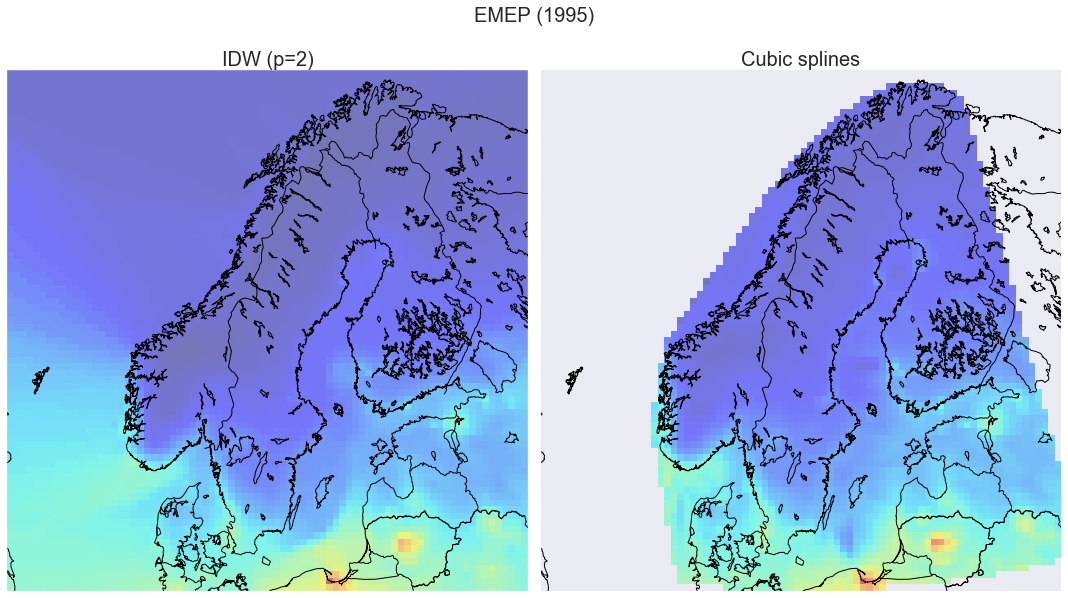

In [12]:
# Set up 25 km grid for interpolation
gridx = np.arange(int(m.xmin), int(m.xmax), 25000)
gridy = np.arange(int(m.ymin), int(m.ymax), 25000)

# Map (long, lat) to projected (x, y)
x, y = m(emep_df['Lon'].values, emep_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))
vals = emep_df[1995].values

# Plot
fig = plt.figure(figsize=(15, 10))

# 1. IDW with p=2
ax = fig.add_subplot(1, 2, 1)

# Perform interpolation
res_idw = idw_interp(pts, vals, gridx, gridy, p=2)

ax.set_title('IDW (p=2)', fontsize=20)
m.imshow(res_idw, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 2. Splines
# Grid to interpolate
xx, yy = np.meshgrid(gridx, gridy) 

ax = fig.add_subplot(1, 2, 2)

# Perform interpolation
res_cs = griddata(pts, vals, (xx, yy), method='cubic')

ax.set_title('Cubic splines', fontsize=20)
m.imshow(res_cs, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

plt.suptitle('EMEP (1995)', fontsize=20, y=0.95)
plt.tight_layout()

# Write to output
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Test_GTiffs'

# IDW
out_path = os.path.join(out_fold, 'emep_1995_idw.tif')
array_to_gtiff(m.xmin, m.ymax, 25000, out_path, res_idw, m.proj4string)

# Spline
out_path = os.path.join(out_fold, 'emep_1995_spl.tif')
array_to_gtiff(m.xmin, m.ymax, 25000, out_path, res_cs, m.proj4string)

The results are compared below. The first thing to notice is that the grids actually line up, which is a relief! The two maps are not identical, but they're pretty similar and I'm happy enough that my code is doing the right thing.

<img src="pic_mountain.jpg" alt="Interpolation comparison" width="800">

## 7. Read arrays to Python

As a final step, I'd like to have code for reading the GeoTiffs back into Python for further manipulation. 

In [13]:
def read_geotiff(geotiff_path):
    """ Reads a GeoTiff file to a numpy array.
    
    Args:
        geotiff_path Path to file
    
    Returns:
        Tuple: (array, NDV, (xmin, xmax, ymin, ymax))
        No data values in the array are set to np.nan
    """
    from osgeo import gdal, gdalconst
    import numpy as np, numpy.ma as ma, sys

    # Register drivers
    gdal.AllRegister()

    # Process the file with GDAL
    ds = gdal.Open(geotiff_path, gdalconst.GA_ReadOnly)
    if ds is None:
        print 'Could not open ' + geotiff_path
        sys.exit(1)

    # Dataset properties
    geotransform = ds.GetGeoTransform()
    originX = geotransform[0]   # Origin is top-left corner
    originY = geotransform[3]   # i.e. (xmin, ymax)
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    
    # Calculate extent
    xmin = int(originX)
    xmax = int(originX + cols*pixelWidth)
    ymin = int(originY + rows*pixelHeight)
    ymax = int(originY)

    # Read band 1
    band = ds.GetRasterBand(1)
    
    # Get NDV
    no_data_val = band.GetNoDataValue()   

    # Read the data to an array
    data = band.ReadAsArray()
    
    # Set NDV to np.nan
    data[data==no_data_val] = np.nan

    # Flip. The data was flipped when it was created (see array_to_gtiff, 
    # above), so need to flip it back. Not sure why this is necessary? 
    # Beware in future!
    data = data[::-1,:]
    
    # Close the dataset
    ds = None

    return (data, no_data_val, (xmin, xmax, ymin, ymax))

As a test, the code below reads the Python and ArcGIS version and displays them side by side, as on the map above.

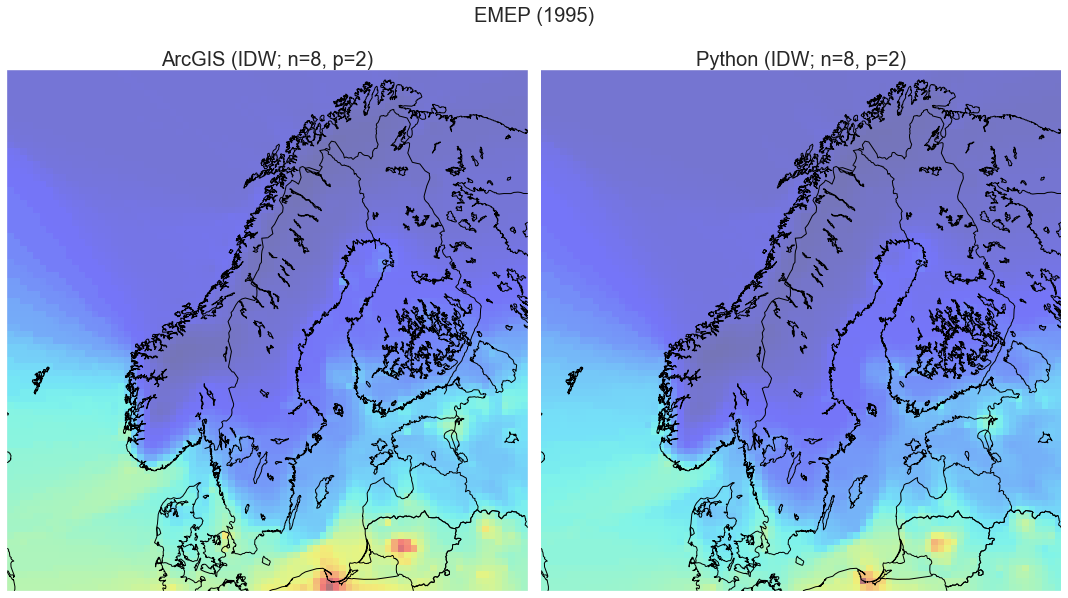

In [14]:
# Read GeoTiffs
py_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Test_GTiffs\emep_1995_idw.tif'
ag_path = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Test_GTiffs\arc_emep_1995_idw.tif'

py_res = read_geotiff(py_path)[0]
ag_res = read_geotiff(ag_path)[0]

# Plot
fig = plt.figure(figsize=(15, 10))

# 1. ArcGIS
ax = fig.add_subplot(1, 2, 1)
ax.set_title('ArcGIS (IDW; n=8, p=2)', fontsize=20)
m.imshow(ag_res, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 2. Python
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Python (IDW; n=8, p=2)', fontsize=20)
m.imshow(py_res, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

plt.suptitle('EMEP (1995)', fontsize=20, y=0.95)
plt.tight_layout()

Finally, note that it's possible to make some cosmetic improvements by smoothing these results a bit further during plotting. This can be done either in ArcGIS under `Display > Resampling`, or in Python by specifying resampling the the call to the [`imshow()`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow) function.  

The code below plots two versions of the ArcGIS output - first the 'raw' interpolated data, and then a cosmetically smoothed version.

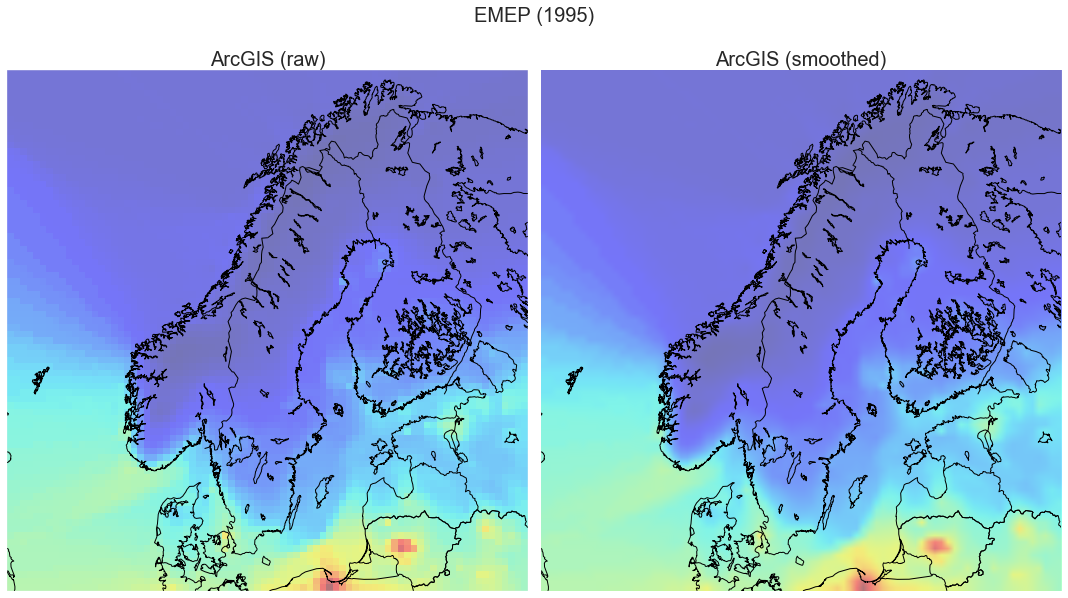

In [15]:
# Plot
fig = plt.figure(figsize=(15, 10))

# 1. Raw
ax = fig.add_subplot(1, 2, 1)
ax.set_title('ArcGIS (raw)', fontsize=20)
m.imshow(ag_res, cmap='jet', alpha=0.5, interpolation='none')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

# 2. Python
ax = fig.add_subplot(1, 2, 2)
ax.set_title('ArcGIS (smoothed)', fontsize=20)
m.imshow(ag_res, cmap='jet', alpha=0.5, interpolation='bilinear')
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)

plt.suptitle('EMEP (1995)', fontsize=20, y=0.95)
plt.tight_layout()